# Anlayzing NYC High School Data
-------------------

# Read in the data

In [2]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [3]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns
Creating DBN column by combining information from different columns

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [11]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [12]:
import matplotlib.pyplot as plt

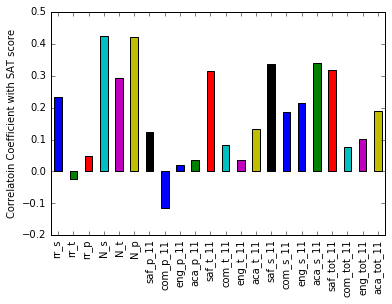

In [13]:
%matplotlib inline
ax = correlations[survey_fields].plot.bar(x=survey_fields, y='sat_score')
ax.set_ylabel("Correlatoin Coefficient with SAT score")

Highest positive correlation with: 
- Number of student respondents
- Number of parent respondents
- Safety and Respect score based on student responses
- Academic expectations score based on student responses
- Safety and Respect total score
- Safety and Respect score based on teacher responses

Lowest negative correlation with:
- Communication score based on parent responses


--------------------------------------

SAT vs Safety score: Schools with low safety scores
-----------------

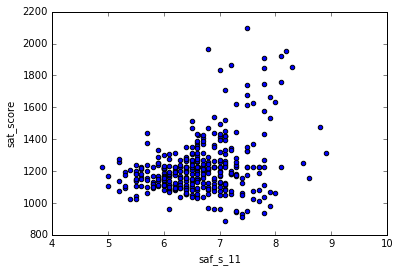

In [14]:
%matplotlib inline
combined.plot.scatter(x='saf_s_11', y='sat_score')

there seems to be a postive correlation between SAT score and Safety and Respect score based on student responses


-----------
Average safety score for each borough:

In [15]:
import numpy as np
sat_sf_boro = combined.groupby('boro').agg(np.mean)[['sat_score', 'saf_s_11']]\
.sort_values(by='saf_s_11')
sat_sf_boro

,sat_score,saf_s_11
boro,,
Brooklyn,1181.364461,6.370755
Staten Island,1382.500000,6.530000
Bronx,1157.598203,6.606577
Queens,1286.753032,6.721875
Manhattan,1278.331410,6.831370


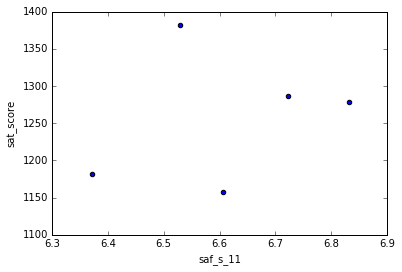

In [16]:
ax = sat_sf_boro.plot.scatter(x='saf_s_11',y='sat_score')


In [17]:
sat_sf_boro.corr()

,sat_score,saf_s_11
sat_score,1.000000,0.257073
saf_s_11,0.257073,1.000000


there is only a weak corelation between overall safety score of boroughs in NYC and the average SAT score

---------------
SAT score vs race
------------

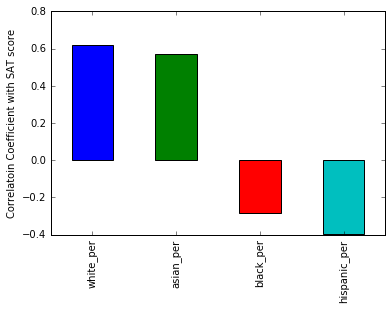

In [18]:
cols = ['white_per', 'asian_per', 'black_per','hispanic_per']
ax = correlations[cols].plot.bar(x=survey_fields, y='sat_score')
ax.set_ylabel("Correlatoin Coefficient with SAT score")

while Asain and White percentage of students in school have strong positive correlation with SAT score, Black and Hispanic percentage of students in school have negative correlation with SAT score 

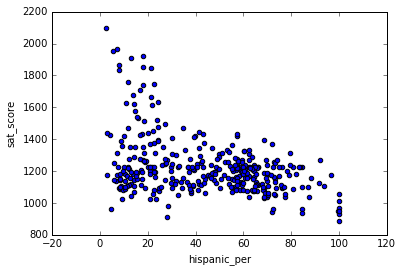

In [20]:
ax = combined.plot.scatter(x='hispanic_per', y='sat_score')

There seems to be a negative correlation between Hispanic percentage of population in a school and the average SAT score of the school

In [23]:
hispanic95 = combined[combined['hispanic_per']>95]
print(hispanic95['SCHOOL NAME'])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


It seems that the schools with high percentage (> 95%) of Hispanic students are the ones with dual language program or with majority of English-leraner students 

In [28]:
hispanic10sat1000 = combined[(combined['hispanic_per']<10) \
                              & (combined['sat_score']>1000)]
print(hispanic10sat1000['SCHOOL NAME'])

37                                STUYVESANT HIGH SCHOOL
46       HIGH SCHOOL FOR DUAL LANGUAGE AND ASIAN STUDIES
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
192                          BEDFORD ACADEMY HIGH SCHOOL
194                            BENJAMIN BANNEKER ACADEMY
220                           BOYS AND GIRLS HIGH SCHOOL
223    ACADEMY FOR COLLEGE PREPARATION AND CAREER EXP...
226               THE HIGH SCHOOL FOR GLOBAL CITIZENSHIP
227                         SCHOOL FOR HUMAN RIGHTS, THE
228                  SCHOOL FOR DEMOCRACY AND LEADERSHIP
229    HIGH SCHOOL FOR YOUTH AND COMMUNITY DEVELOPMEN...
230        HIGH SCHOOL FOR SERVICE & LEARNING AT ERASMUS
231    SCIENCE, TECHNOLOGY AND RESEARCH EARLY COLLEGE...
235              MEDGAR EVERS COLLEGE PREPARATORY SCHOOL
236                             CLARA BARTON HIGH SCHOOL
238                           BROOKLYN GENERATION SCHOOL
240              KURT HAHN EXPE

It seems that among the schools with low percentage (< 10%) of Hispanic and relatively high SAT scores (> 1000) are the ones with college preparations programs, scince and technical schools and dual language program scholls for Asians

-------------
SAT score vs gender
-----------

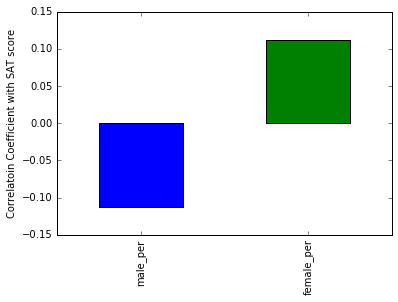

In [30]:
cols = ['male_per', 'female_per']
ax = correlations[cols].plot.bar(x=survey_fields, y='sat_score')
ax.set_ylabel("Correlatoin Coefficient with SAT score")

Male percentage of students in a school has a slight negative correlation with it's SAT score while the female percentage of students in a school has a slight positive correlation with it's SAT score.

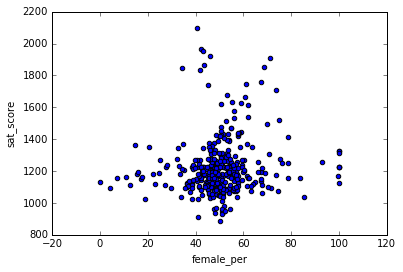

In [31]:
ax = combined.plot.scatter(x='female_per', y='sat_score')

In [32]:
female60sat1700 = combined[(combined['female_per']>60) \
                    & (combined['sat_score']>1700)]
print(female60sat1700['SCHOOL NAME'])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


It seems that among the schools with high percentage (< 60%) of female students and high SAT scores (> 1700) are the ones with a highly selective schools and early college programs

----------
SAT score vs AP score
------------

Calculating the percentage of students in each school that took an AP exam:

In [35]:
combined['ap_per'] = combined ['AP Test Takers '] / combined['total_enrollment']

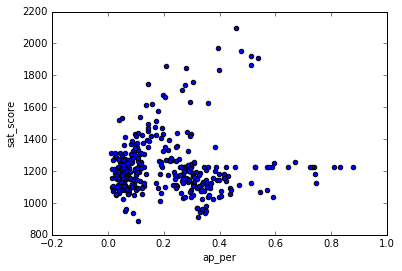

In [36]:
ax = combined.plot.scatter(x='ap_per', y='sat_score')

In [39]:
combined[['sat_score', 'ap_per']].corr()

,sat_score,ap_per
sat_score,1.000000,0.057171
ap_per,0.057171,1.000000


In general there is no strong correlation between percentage of students who take AP exam and SAT score: based on the scatter plot above it seems that the correlation only exists for a part of data